# Outlier filtering with focus on phase diagram

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from astropy.coordinates import SkyCoord
from functools import partial
import os
os.chdir('/home/jovyan/work/src')
import do_charts_vast
import reading
import utils
from star_description import StarDescription

%matplotlib inline
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

## Supporting functions

In [2]:
def massage_df_for_phase_plot(df: DataFrame):
    df['floatJD'] = df['JD'].astype(np.float)
    df['realV'] = df['Vrel']
    df['realErr'] = df['err']
    return df

In [3]:
def perc_change_filter(df: DataFrame, column: str, perc=.3):
#     df["norm"] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
#     df["change"] =df["norm"].pct_change()
    df["change"] =df[column].pct_change()
#     print("norm", df["norm"].describe())
    print("change", df["change"].describe())
    df[np.isfinite(df['change'])]['change'].hist()
    #     del df["norm"]
    #     del df["change"]
    return df[(abs(df["change"]) < perc)]

def abs_change_filter(df: DataFrame, column: str, perc=.3):
#     meanv = df[column].mean()
    df["change"] =abs(df[column].diff())
    print("change", df["change"].describe())
    df[np.isfinite(df['change'])]['change'].hist()
    #     del df["norm"]
    #     del df["change"]
    return df[(df["change"] > perc)]


def less_than_filter(df: DataFrame, column: str, max=.1):
    df[np.isfinite(df[column])][column].hist()
    return df[(abs(df[column]) < max)]

def none_phase_filter(time, lc):
    return time, lc

In [4]:
def read_light_curve(star_id):
    df = reading.read_lightcurve_vast(f"../tests/data/outliers/out{star_id:05}.dat")
    return massage_df_for_phase_plot(df)
 
def plot_star(star_id, cleaning_func):
    df = read_light_curve(star_id)
    return plot_star_df(star_id, df, cleaning_func)

def plot_star_df(star_id, df, cleaning_func):
    star = StarDescription(local_id=star_id, coords=SkyCoord(ra=5.6, dec=-72, unit='deg'))
    print("curve before cleaning:", len(df))
    period = do_charts_vast.calculate_ls_period_from_df(df)
    print("using period", period)
    plt, t, lc = do_charts_vast.plot_phase_diagram(star, df, "bla", write_plot=False, filter_func=cleaning_func, period=period)
    print("curve after cleaning:", len(lc))
    plt.show()
    return t, lc

In [5]:
iqr_func = partial(utils.reject_outliers_iqr, column="realV", cut=20)
perc_func = partial(perc_change_filter, column="realV", perc=.2)
abs_func = partial(abs_change_filter, column="realV", perc=.4)
less_than_func = partial(less_than_filter, column="realErr", max=.1)
none_func = lambda x: x

## Reading light curves

8086
change count    8085.000000
mean        0.145340
std         0.109038
min         0.000033
25%         0.057188
50%         0.122381
75%         0.214419
max         0.781597
Name: change, dtype: float64
1


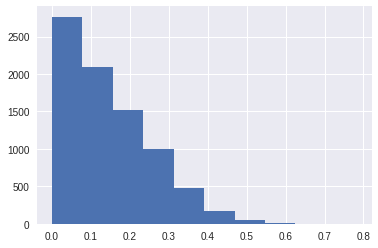

In [28]:
test_curve = read_light_curve(3855)
print(len(test_curve))
# perc_result = perc_change_filter(test_curve, "realV", perc=.8)
result = abs_change_filter(test_curve, "realV", perc=.7)
print(len(result))
# print("change", perc_result["change"].describe())
# print("norm", perc_result["norm"].describe())

curve before cleaning: 8086
using period Period(period=0.1467744030721135, origin='LS')
curve after cleaning: 8086


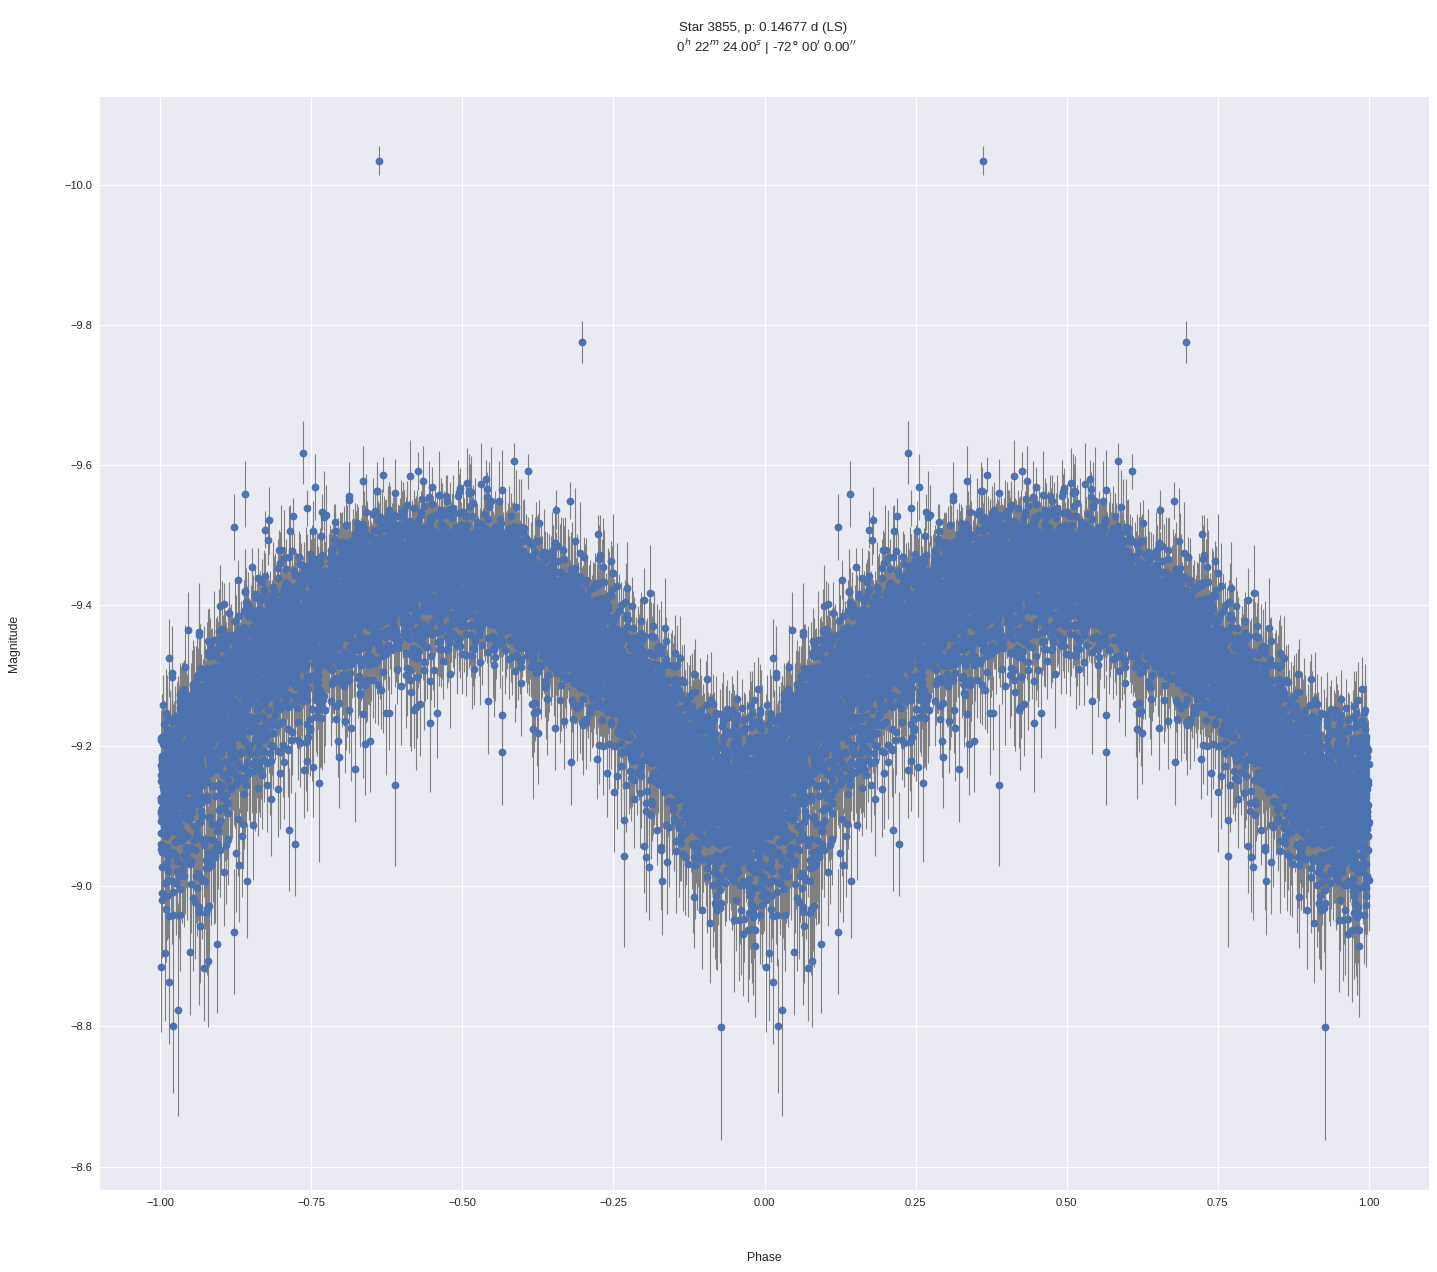

curve before cleaning: 8415
using period Period(period=0.2089661000731542, origin='LS')
curve after cleaning: 8415


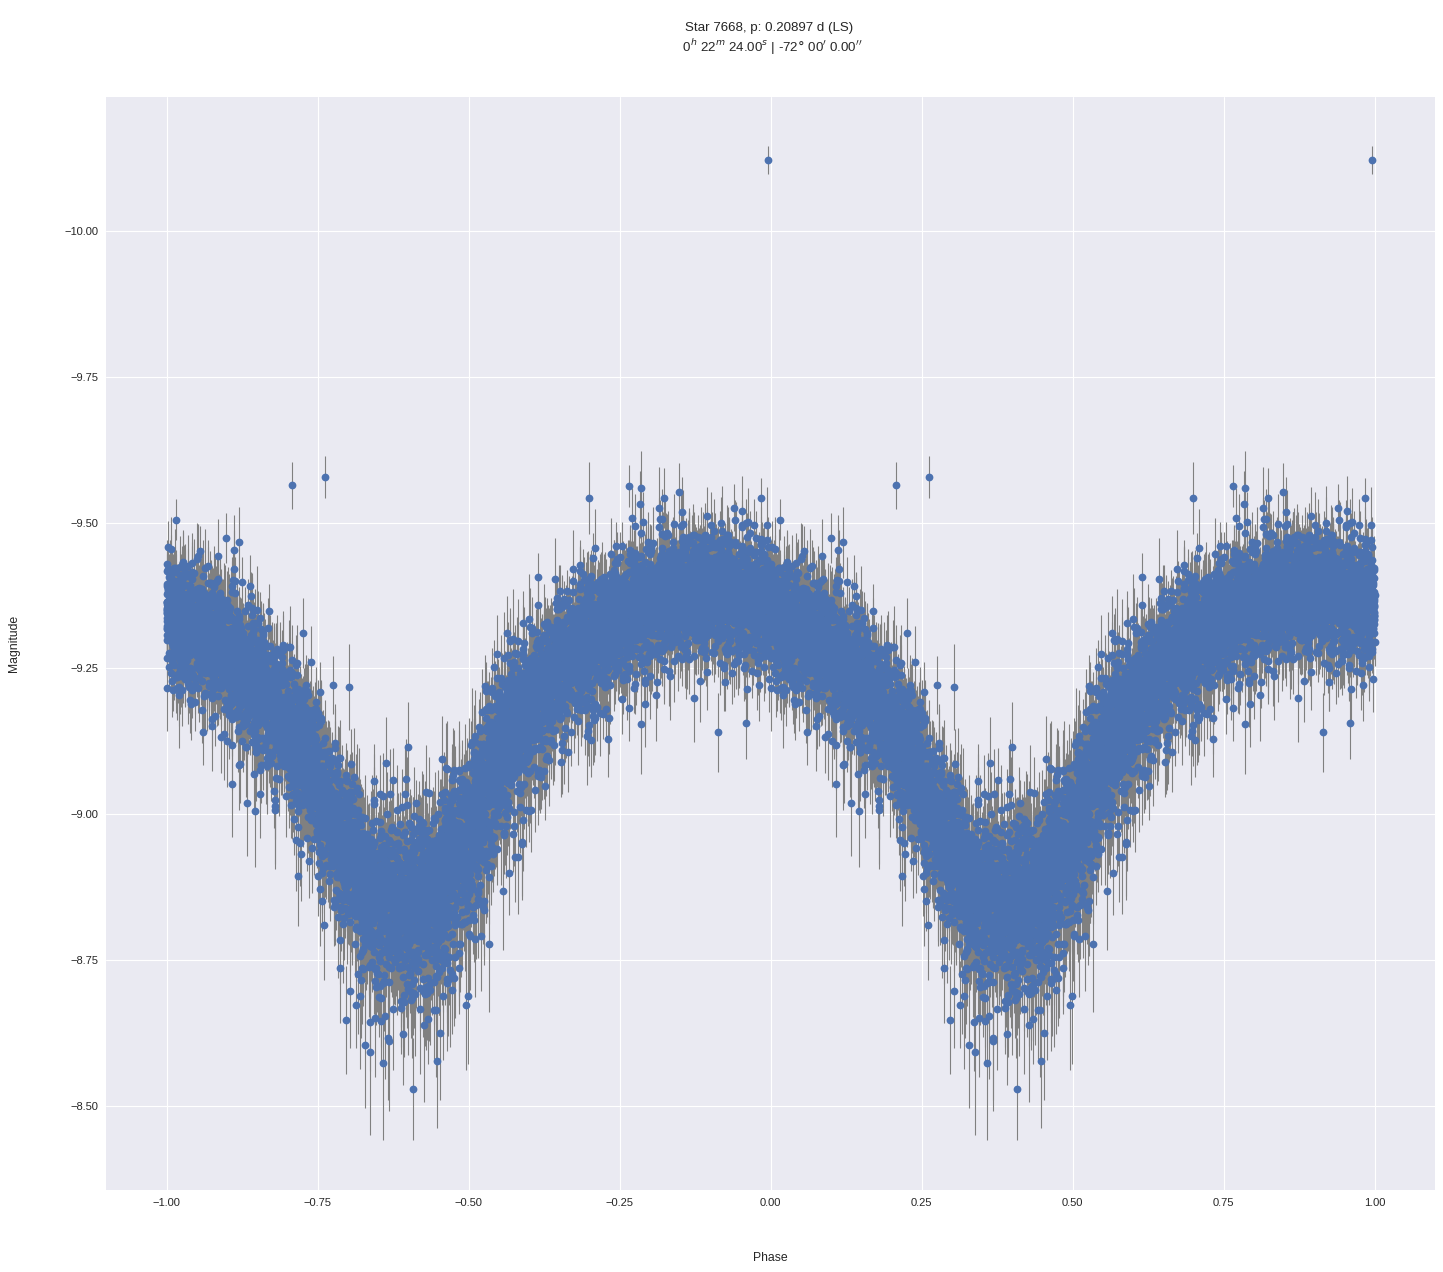

curve before cleaning: 7752
using period Period(period=1.8082813826497859, origin='LS')
curve after cleaning: 7752


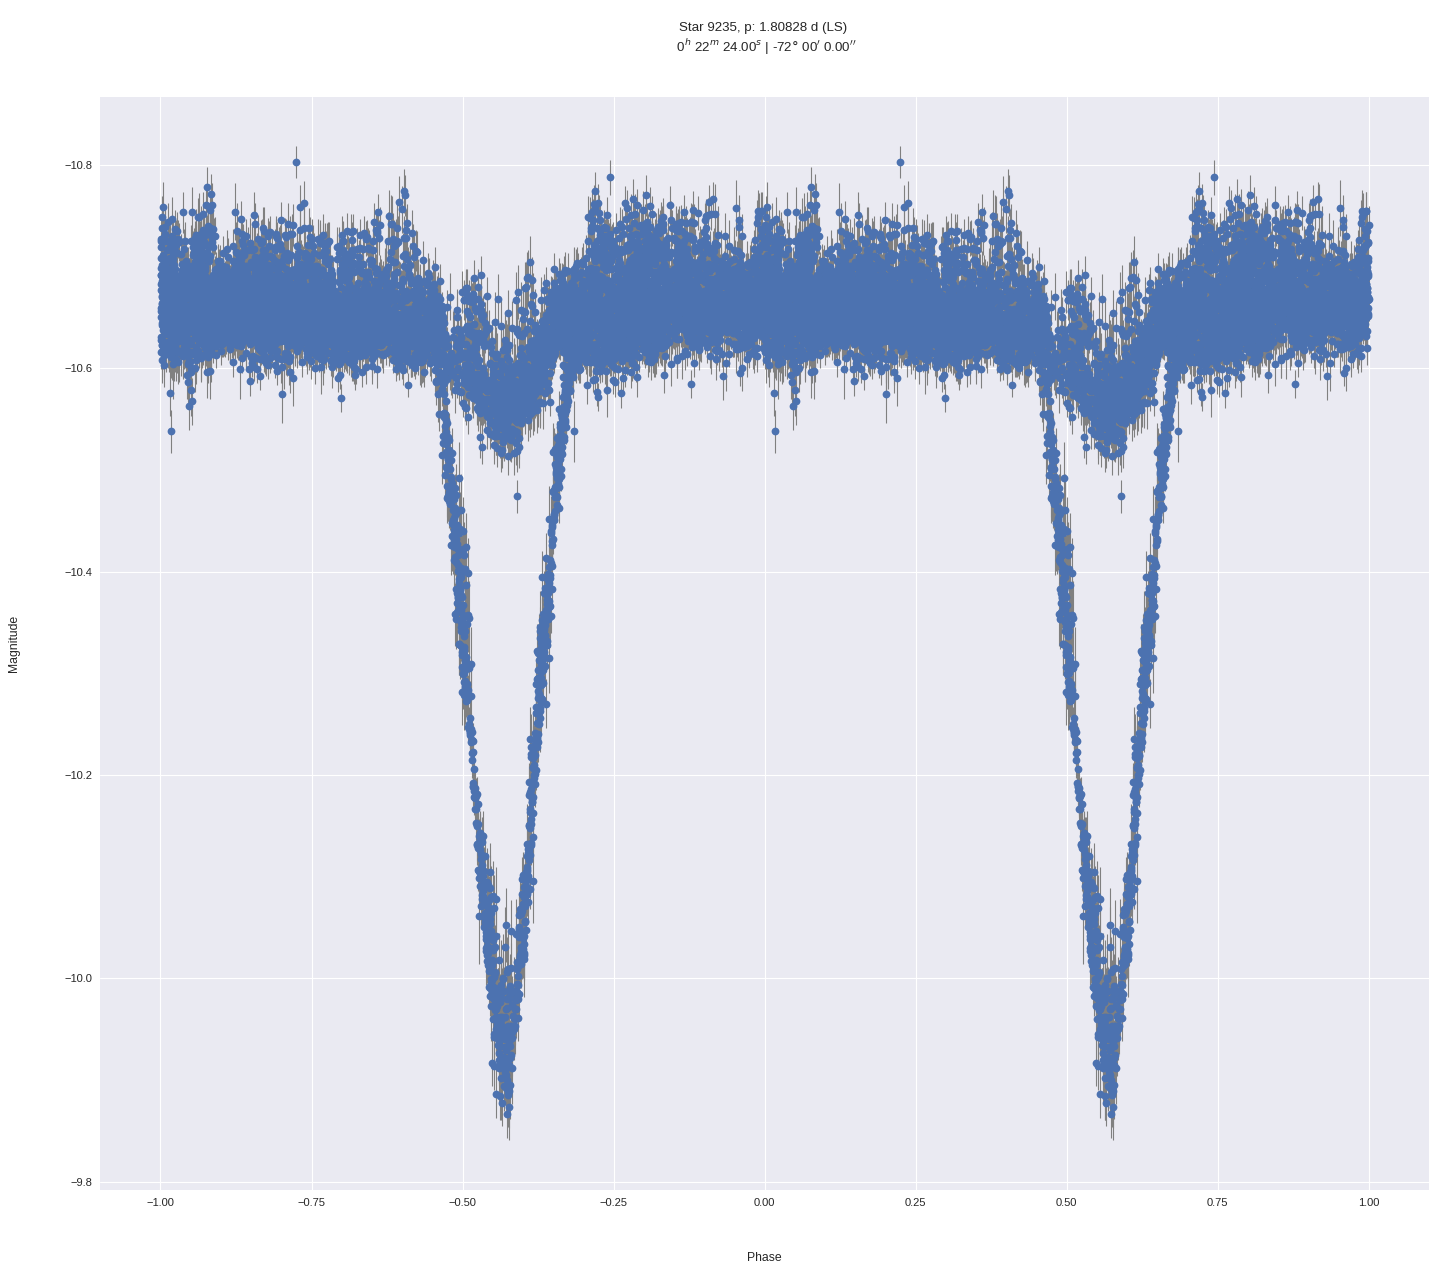

CPU times: user 4.97 s, sys: 690 ms, total: 5.66 s
Wall time: 5.41 s


In [7]:
stars = [3855, 7668, 9235]
one_star = [3855]
t=[]
lc=[]
def plot_stars(stars, outlier_func):
    for star in stars:
        t, lc = plot_star(star, outlier_func)

%time plot_stars(stars, none_phase_filter)

## Star 3855, grouped

min max is -10.03441811 -8.79940987
1106 <class 'numpy.int64'>
argmin 1106 -10.03441811
length of curve is 8086
number of buckets: 11
Cleaning removed 4 points
curve before cleaning: 8082
using period Period(period=0.14677427820852346, origin='LS')
curve after cleaning: 8082


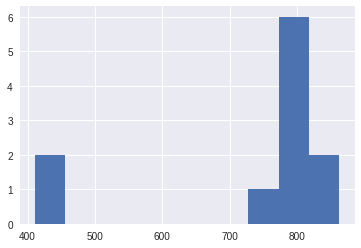

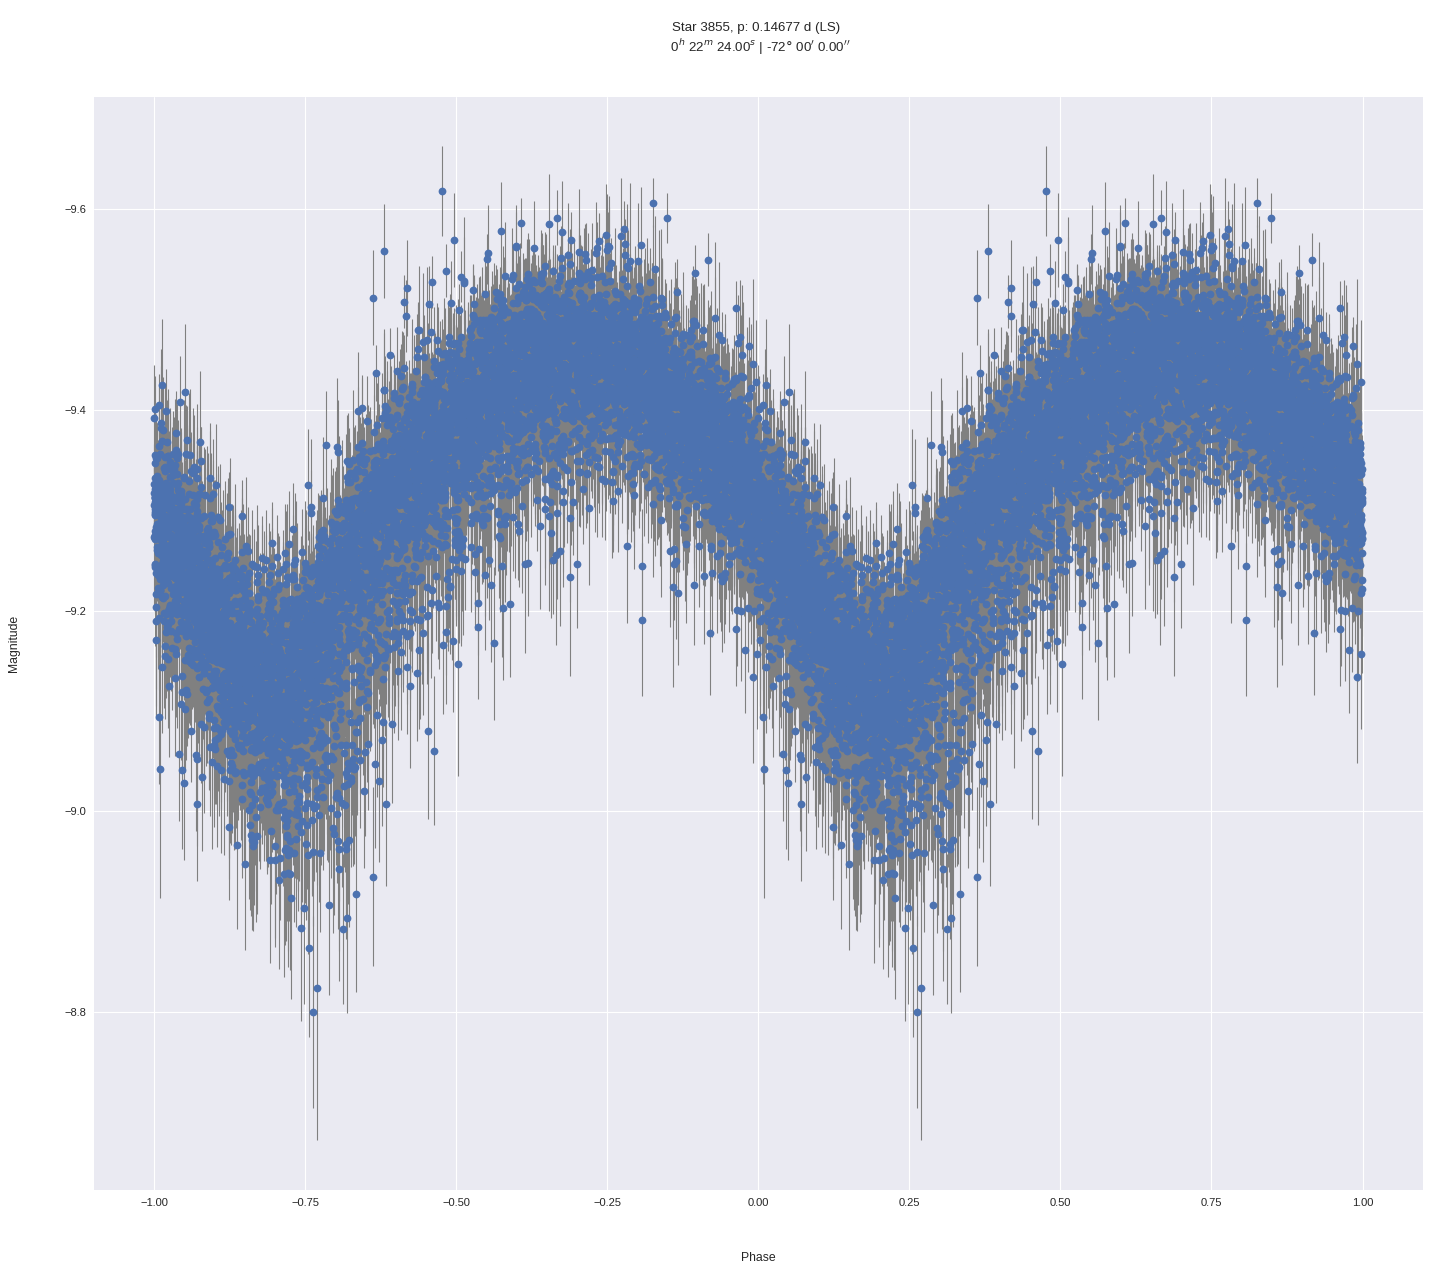

min max is -10.1210992 -8.52964035
6165 <class 'numpy.int64'>
argmin 6165 -10.1210992
length of curve is 8415
number of buckets: 11
Cleaning removed 3 points
curve before cleaning: 8412
using period Period(period=0.2089661000731542, origin='LS')
curve after cleaning: 8412


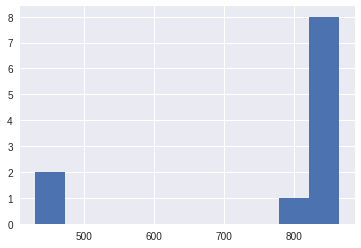

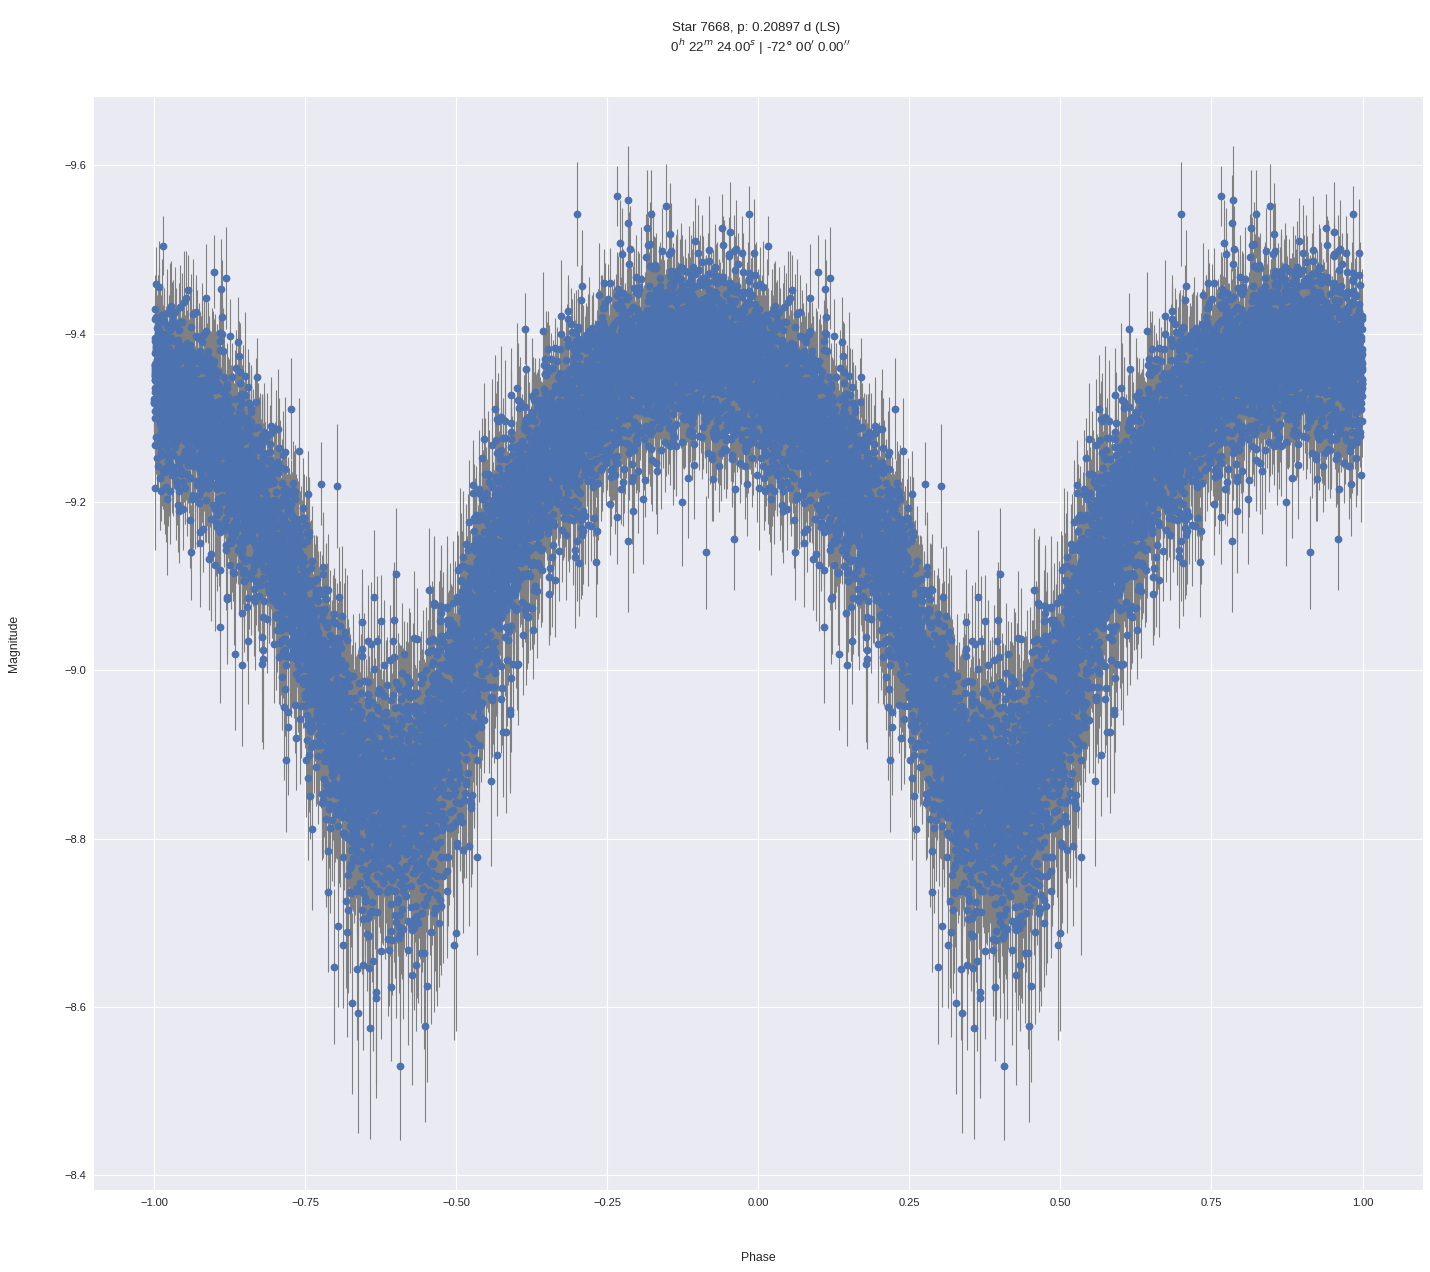

min max is -10.80264919 -9.86597724
1755 <class 'numpy.int64'>
argmin 1755 -10.80264919
length of curve is 7752
number of buckets: 11
Cleaning removed 0 points
curve before cleaning: 7752
using period Period(period=1.8082813826497859, origin='LS')
curve after cleaning: 7752


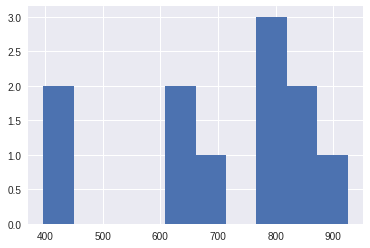

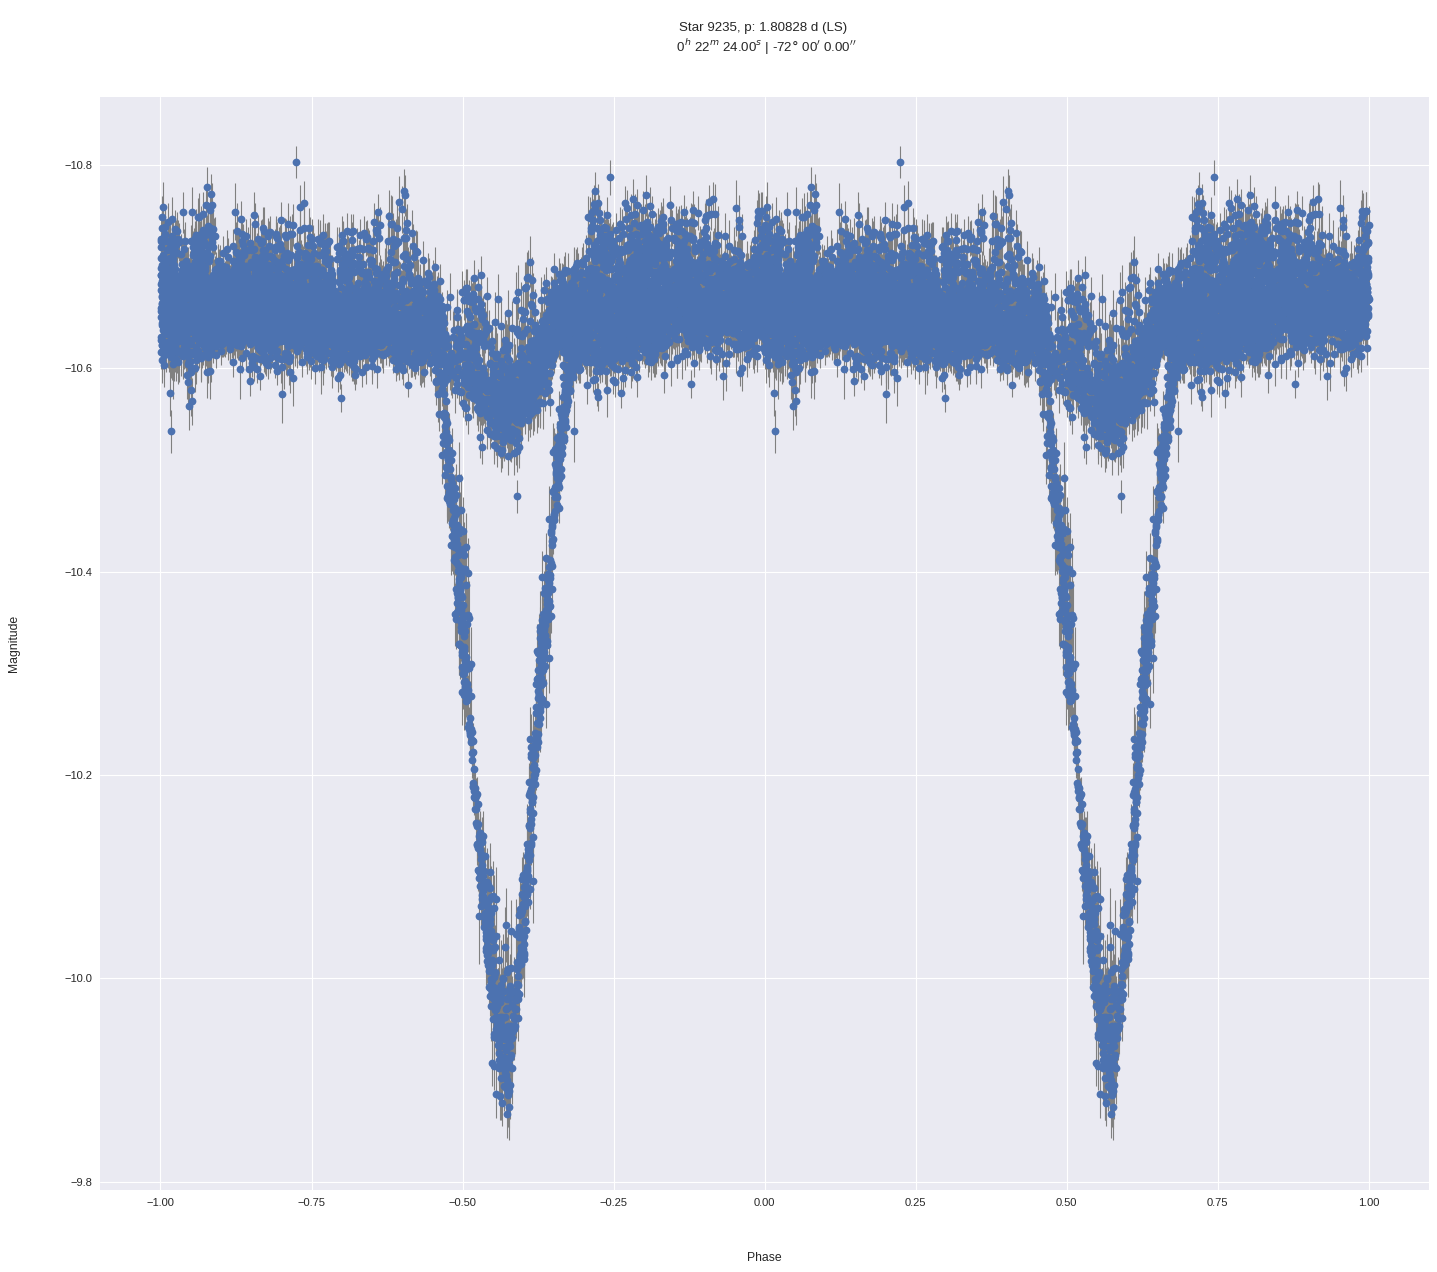

In [118]:
def clean(star):
    df = read_light_curve(star)
    print("min max is", df['realV'].min(), df['realV'].max())
    minimum = np.argmin(np.array(df['realV']))
    print(minimum, type(minimum))
    print("argmin", minimum, df['realV'].iloc[minimum])
    period = do_charts_vast.calculate_ls_period_from_df(df)
    phased_t = np.fmod(df['floatJD'] / period.period, 1)
    # array of times rounded to 1 decimal (==2.4 hours) (not folded yet)
    grouper = np.round(phased_t, 1)
    print("length of curve is", len(df))
    df_v_grouped = df.groupby(grouper)
    ind = df_v_grouped.indices
    print("number of buckets:", len(ind.keys()))
    sum = 0

    Series([len(x) for label, x in df_v_grouped]).hist()

    maskresult = pd.DataFrame()
    for bucket_label, bucket_all in df_v_grouped:
        bucket = bucket_all['realV']
        bucketmean = bucket.median()
        bucketstd = bucket.std()
        mask = abs(bucket - bucketmean) < 5*bucketstd
        maskresult = maskresult.append(bucket_all[mask])
    print(f"Cleaning removed {len(df)-len(maskresult)} points")
    plot_star_df(star, maskresult, lambda x,y: (x,y))
    
stars = [3855, 7668, 9235]
for star in stars:
    clean(star)

In [60]:
sum = 0
for label, entry in df_v_grouped:
    sum = sum + len(entry)
    print("label", label, "entry", len(entry))
#     print(entry)
print(sum)
print(len(df['floatJD']))
print(len(phased_t))
print(dir(df_v_grouped))
print(df_v_grouped.get_group(0.0))

label 0.0 entry 411
label 0.1 entry 796
label 0.2 entry 812
label 0.3 entry 793
label 0.4 entry 798
label 0.5 entry 753
label 0.6 entry 823
label 0.7 entry 813
label 0.8 entry 863
label 0.9 entry 811
label 1.0 entry 413
8086
5775
8086
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_accessors', '_add_numeric_operations', '_agg_examples_doc', '_agg_see_also_doc', '_aggregate', '_aggregate_multiple_funcs', '_aggregate_named', '_apply_filter', '_apply_to_column_groupbys', '_apply_whitelist', '_assure_grouper', '_bool_agg', '_builtin_table', '_concat_objects', '_constructor', '_cumcount_array', '_cython_agg_general', '_cython_table', '_cython_tr